# 0. 环境准备

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 设置pandas可以显示的行数和列数
pd.options.display.max_rows = 400
pd.options.display.max_columns = None

# 忽略warnings
import warnings
warnings.filterwarnings("ignore")

#推荐安装插件： nbextensions

# 1. 读入数据

## 股价数据

In [2]:
# date: 日期
# company: 公司代码
# price: 股价
df_stock = pd.read_csv('data/stock_price.csv', parse_dates=['date'])
df_stock.head(2)

,date,company,price
0,2012-05-18,FB,38.230000
1,2012-05-21,FB,34.029999


## 商品销量

In [3]:
# store:门店编号
# dept: 商品部门编号
# week: 每周周一的日期 
# sales: 销售金额
df_sales = pd.read_csv('data/store_sales.csv', parse_dates=['week'])
df_sales.head(2)

,store,dept,week,sales
0,1,1,2010-02-01,24924.50
1,1,1,2010-02-08,46039.49


# 2. 时间序列的可视化

## 简单时序图，用于对时间数据进行初步观察

### 股价数据，以FB的股价为例

(array([14975., 15340., 15706., 16071., 16436., 16801., 17167., 17532.,
        17897., 18262., 18628., 18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

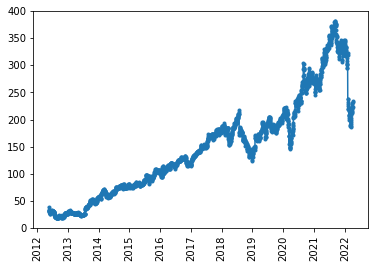

In [4]:
# 全时序图
df = df_stock[ df_stock['company']=='FB' ].sort_values('date')
plt.plot( df['date'], df['price'],'.-' )
plt.xticks(rotation=90)

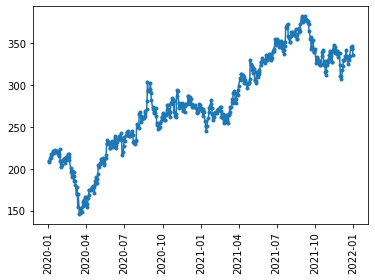

In [5]:
# 局部时序图
df = df_stock[ (df_stock['company']=='FB') & 
             (df_stock['date']>='2020-01-01') & 
             (df_stock['date']<='2021-12-31')].sort_values('date')
plt.plot( df['date'], df['price'],'.-' )
plt.xticks(rotation=90)
plt.show()

结论：FB的股价总体呈现上市的趋势，局部有波动

### 销售数据， 以1号店的1号部门为例

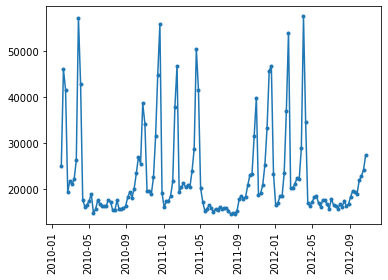

In [6]:
# 全时序图
df = df_sales[ (df_sales['store']==1) & 
             (df_sales['dept']==1)].sort_values('week')
plt.plot( df['week'], df['sales'],'.-' )
plt.xticks(rotation=90)
plt.show()

结论: 1号店1号部门的销售呈现出以1年（既52周）为单位的周期性

## 季节性时序图

### 数据准备

In [7]:
# 以1号店1号部门的销售数据为例
df = df_sales[ (df_sales['store']==1) & 
             (df_sales['dept']==1)].sort_values('week')

#计算每周属于哪一年
df['year'] = df['week'].dt.year

#计算每周为一年当中的第几周
df['week_of_year'] = df['week'].dt.weekofyear

### 作图

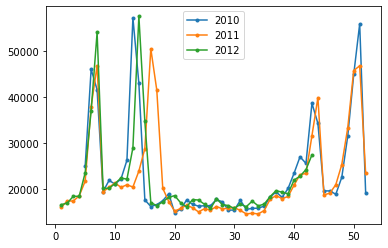

In [8]:
for year in df['year'].unique():
    tmp_df = df[ df['year']==year ]
    plt.plot( tmp_df['week_of_year'], tmp_df['sales'],'.-', label=str(year) )
plt.legend()
plt.show()

结论： 
1. 每年19周-43周（4-10月）是销售的低估
2. 每年44周-次年18周（10-4月）疑似有促销活动
3. 趋势上11年略低于10和12年

## 季节性箱线图

### 数据准备

In [9]:
# 以1号店1号部门的销售数据为例
df = df_sales[ (df_sales['store']==1) & 
             (df_sales['dept']==1)].sort_values('week')

#计算每周为一年当中的第几周
df['week_of_year'] = df['week'].dt.weekofyear

#将一年当中同一周的数据汇集到一个list
df_boxplot = df.groupby(['week_of_year'])['sales'].agg(list).reset_index()

### 作图

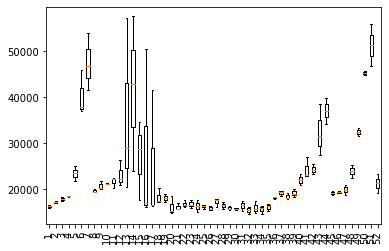

In [10]:
plt.boxplot( df_boxplot['sales'].values, labels=df_boxplot['week_of_year'].values )
plt.xticks(rotation=90)
plt.show()

## 趋势箱线图

### 数据准备

In [11]:
# 以1号店1号部门的销售数据为例
df = df_sales[ (df_sales['store']==1) & 
             (df_sales['dept']==1)].sort_values('week')

#计算每周属于哪一年
df['year'] = df['week'].dt.year

#计算每周为一年当中的第几周
df['week_of_year'] = df['week'].dt.weekofyear

#只保留19-43周的数字，因为其他周受促销活动的干扰
df = df[ (df['week_of_year']>=19) & 
       (df['week_of_year']<=43)]

#将同一年数据汇集到一个list
df_boxplot = df.groupby(['year'])['sales'].agg(list).reset_index()

### 作图

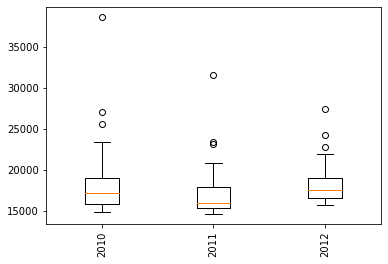

In [12]:
plt.boxplot( df_boxplot['sales'].values, labels=df_boxplot['year'].values )
plt.xticks(rotation=90)
plt.show()

# 如何判断周期性

ACF检验 (Auto-Correlation Function, 自相关系数检验） 
$$ r_h = Cor( X_t, X_{t+h} ) , \forall t$$
如果每隔h个单位，ACF值有一个局部高峰，则数据存在以h为单位的周期性

## 数据准备

In [13]:
# 以1号店1号部门的销售数据为例
df = df_sales[ (df_sales['store']==1) & 
             (df_sales['dept']==1)].sort_values('week')

## 计算周期性

In [14]:
from  statsmodels.graphics.tsaplots import plot_acf

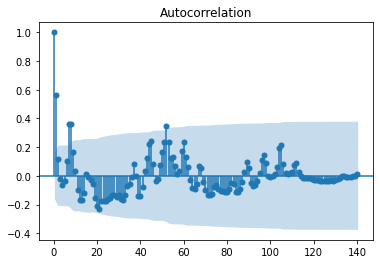

In [15]:
plot_acf(df['sales'], lags=140).show()

结论：数据存在以52周（1年）为单位的周期性

# 3. 用STL算法分解时间序列

## 数据准备

In [16]:
# 以1号店1号部门的销售数据为例
df = df_sales[ (df_sales['store']==1) & 
             (df_sales['dept']==1)].sort_values('week')

## STL分解

In [17]:
from statsmodels.tsa.seasonal import STL

In [18]:
stl = STL(df['sales'].values, period=52) #period: 时间序列的周期
res = stl.fit()

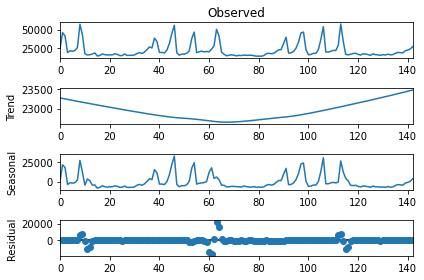

In [19]:
## 分解结果可视化
fig = res.plot()

In [20]:
## 获取结果数字
df['trend'] = res.trend
df['seasonal'] = res.seasonal
df['residule'] = res.resid